# Big Mart Item Sales Prediction per SKU per Store

# Explainable AI (XAI)

Many people say machine learning models are "black boxes", in the sense that they can make good predictions but you can't understand the logic behind those predictions. 
However, this week you will learn techniques to extract the following insights from sophisticated machine learning models.

- What features in the data did the model think are most important?
- How does each feature affect the model's predictions in a big-picture sense: what is its typical effect when considered over a large number of possible predictions?

## Why Are Feature Insights Valuable?

Feature insights have many uses, including
- Debugging
- Informing feature engineering
- Directing future data collection
- Informing human decision-making
- Building Trust


### Debugging
The world has a lot of unreliable, disorganized and generally dirty data. You add a potential source of errors as you write preprocessing code. Add in the potential for target leakage, and it is the norm rather than the exception to have errors at some point in a real data science project.

Given the frequency and potentially disastrous consequences of bugs, debugging is one of the most valuable skills in data science. Understanding the patterns a model is finding will help you identify when those are at odds with your knowledge of the real world, and this is typically the first step in tracking down bugs.

### Informing Feature Engineering
Feature engineering is usually the most effective way to improve model accuracy. Feature engineering usually involves repeatedly creating new features using transformations of your raw data or features you have previously created. 

Sometimes you can go through this process using nothing but intuition about the underlying topic. But you'll need more direction when you have 100s of raw features or when you lack background knowledge about the topic you are working on. As an increasing number of datasets start with 100s or 1000s of raw features, this approach is becoming increasingly important.

### Directing Future Data Collection
You have no control over datasets you download online. But many businesses and organizations using data science have opportunities to expand what types of data they collect. Collecting new types of data can be expensive or inconvenient, so they only want to do this if they know it will be worthwhile. Model-based insights give you a good understanding of the value of features you currently have, which will help you reason about what new values may be most helpful.

### Informing Human Decision-Making
Some decisions are made automatically by models. Amazon doesn't have humans (or elves) scurry to decide what to show you whenever you go to their website.  But many important decisions are made by humans. For these decisions, insights can be more valuable than predictions.

### Building Trust
Many people won't assume they can trust your model for important decisions without verifying some basic facts. This is a smart precaution given the frequency of data errors. In practice, showing insights that fit their general understanding of the problem will help build trust, even among people with little deep knowledge of data science.

## Setting Up the Workspace

In [ ]:
!pip install eli5 shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 216.2/216.2 KB 7.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 572.4/572.4 KB 28.3 MB/s eta 0:00:00
  Created wheel for eli5: filename=eli5-0.13.0-py2.py3-none-any.whl size=107748 sha256=331249ed32e76b2bb2a939a4d1fccc11394da4c0aa8b6386d93b1d2cc6f92af4
  Stored in directory: /root/.cache/pip/wheels/7b/26/a5/8460416695a992a2966b41caa5338e5e7fcea98c9d032d055c
Successfully built eli5


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn import set_config
from sklearn.pipeline import Pipeline

import eli5 # package used for feature permutation importance
from eli5.sklearn import PermutationImportance
from sklearn.ensemble import RandomForestRegressor

import xgboost as xgb
import shap  # package used for Shapley additive explanations

## Loading the Data

The data scientists at BigMart have collected 2013 sales data for 1559 products across 10 stores in different cities. Also, certain attributes of each product and store have been defined. The aim is to build a predictive model and predict the sales of each product at a particular outlet.

Using this model, BigMart will try to understand the properties of products and outlets which play a key role in increasing sales.

Please note that the data may have missing values as some stores might not report all the data due to technical glitches. Hence, it will be required to treat them accordingly.


### Features

|        Column Name        |                                             Description                                             |
|:-------------------------:|:---------------------------------------------------------------------------------------------------:|
| Item_Identifier           | Unique product ID                                                                                   |
| Item_Weight               | Weight of product                                                                                   |
| Item_Fat_Content          | Whether the product is low fat or regular                                                           |
| Item_Visibility           | The percentage of total display area of all products in a store allocated to the particular product |
| Item_Type                 | The category to which the product belongs                                                           |
| Item_MRP                  | Maximum Retail Price (list price) of the product (in rupees)                                        |
| Outlet_Identifier         | Unique store ID                                                                                     |
| Outlet_Establishment_Year | The year in which store was established                                                             |
| Outlet_Size               | The size of the store in terms of ground area covered                                               |
| Outlet_Location_Type      | The type of area in which the store is located                                                      |
| Outlet_Type               | Whether the outlet is a grocery store or some sort of supermarket                                   |
| Item_Outlet_Sales         | Sales of the product in the particular store. This is the target variable to be predicted.          |


In [ ]:
df_sales = pd.read_csv('https://www.dropbox.com/s/yqaymhdf7bvvair/bigmart_sales_predictions.csv?dl=1')
df_sales.head(5)

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


Remove columns we will not use today

In [ ]:
df_sales = df_sales.drop(columns=['Item_Identifier', 'Outlet_Identifier', 'Outlet_Establishment_Year'])

Check for potential duplicated records

In [ ]:
df_sales.duplicated().sum()

0

There are no duplicated records, but are there missing values?

In [ ]:
df_sales.isna().sum()

Item_Weight             1463
Item_Fat_Content           0
Item_Visibility            0
Item_Type                  0
Item_MRP                   0
Outlet_Size             2410
Outlet_Location_Type       0
Outlet_Type                0
Item_Outlet_Sales          0
dtype: int64

There are missing values! 
Remember the pipeline we showed you in class before? 

We will use that to impute the values for `item_weight` and `Outlet_Size`. As we can see in the `value_counts()` below, `Outlet_Size` is an excellent candidate for an ordinal encoding.

In [ ]:
df_sales['Outlet_Size'].value_counts()

Medium    2793
Small     2388
High       932
Name: Outlet_Size, dtype: int64

To clean up the column `Item_Fat_Content` we manually consolidate the 5 values into two values in an ordinal way.

In [ ]:
df_sales['Item_Fat_Content'].value_counts()

Low Fat    5089
Regular    2889
LF          316
reg         117
low fat     112
Name: Item_Fat_Content, dtype: int64

In [ ]:
df_sales['Item_Fat_Content'] = df_sales['Item_Fat_Content'].replace(
    {'Low Fat': 'low',
     'LF': 'low',
     'low fat': 'low',
     'Regular': 'regular',
     'reg': 'regular'})
df_sales['Item_Fat_Content'].value_counts()

low        5517
regular    3006
Name: Item_Fat_Content, dtype: int64

In [ ]:
df_sales.dtypes

Item_Weight             float64
Item_Fat_Content         object
Item_Visibility         float64
Item_Type                object
Item_MRP                float64
Outlet_Size              object
Outlet_Location_Type     object
Outlet_Type              object
Item_Outlet_Sales       float64
dtype: object

### Visualizations

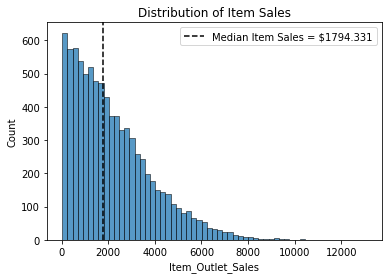

In [ ]:
# Create histograms to view distributions of various features in the dataset 
ax = sns.histplot(data = df_sales, x = 'Item_Outlet_Sales')
median = df_sales['Item_Outlet_Sales'].median()
ax.set(title = 'Distribution of Item Sales')
ax.axvline(median, color = 'black', linestyle = '--', 
            label = f'Median Item Sales = ${median}')
ax.legend();

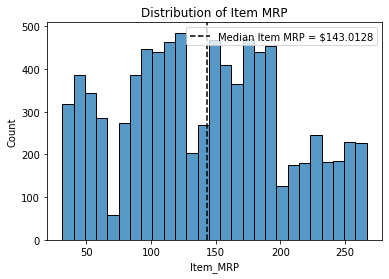

In [ ]:
# Create histograms to view distributions of various features in the dataset 
ax = sns.histplot(data = df_sales, x = 'Item_MRP')
median = df_sales['Item_MRP'].median()
ax.set(title = 'Distribution of Item MRP')
ax.axvline(median, color = 'black', linestyle = '--', 
            label = f'Median Item MRP = ${median}')
ax.legend();

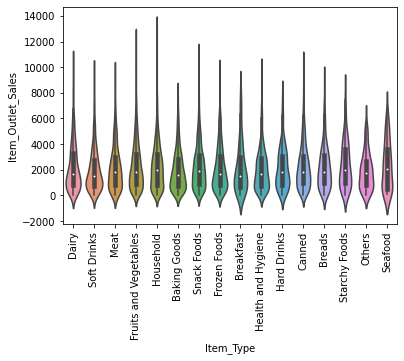

In [ ]:
# Create boxplots to view statistical summaries of Item_Type and Item_Outlet_Sales
sns.violinplot(x = 'Item_Type', y = 'Item_Outlet_Sales', data = df_sales)
plt.xticks(rotation = 90);

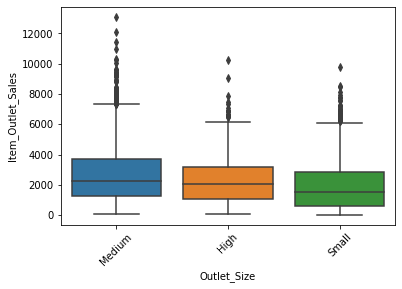

In [ ]:
# Create boxplots to view statistical summaries of Outlet_Size and Item_Outlet_Sales
sns.boxplot(x = 'Outlet_Size', y = 'Item_Outlet_Sales', data = df_sales)
plt.xticks(rotation = 45);

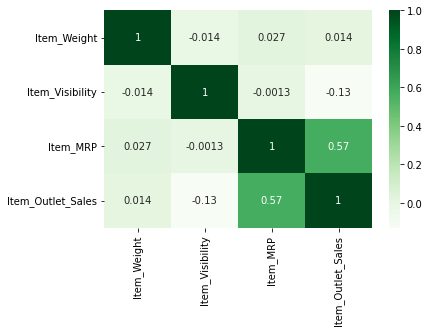

In [ ]:
# Display correlation between features
corr = df_sales.corr()
sns.heatmap(corr, cmap = 'Greens', annot = True);

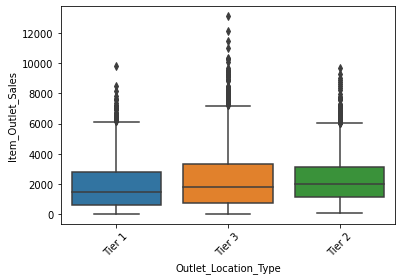

In [ ]:
# Create boxplots to view statistical summaries of Outlet_Location_Type and Item_Outlet_Sales
sns.boxplot(x = 'Outlet_Location_Type', y = 'Item_Outlet_Sales', data = df_sales)
plt.xticks(rotation = 45);

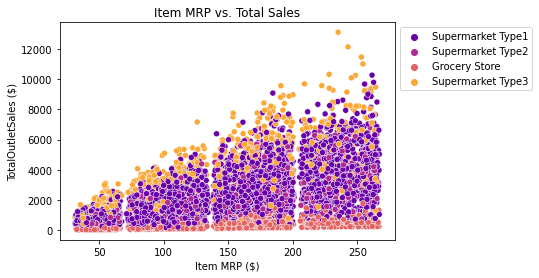

In [ ]:
# Construct scatterplot of Item_MRP and Sales
ax = sns.scatterplot(data = df_sales, x = 'Item_MRP', y = 'Item_Outlet_Sales', hue = 'Outlet_Type', palette = 'plasma')
ax.set_title('Item MRP vs. Total Sales')
ax.set_xlabel('Item MRP ($)')
ax.set_ylabel('TotalOutletSales ($)')
ax.legend(bbox_to_anchor = [1,1]);

### Pipeline

In [ ]:
#from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
#from sklearn.impute import SimpleImputer
#from sklearn.compose import make_column_transformer, make_column_selector
#from sklearn.pipeline import make_pipeline
#from sklearn.model_selection import train_test_split
#from sklearn import set_config
#from sklearn.pipeline import Pipeline

#Establish each pipeline for differente feature types
categorical_features = ['Item_Type','Outlet_Location_Type','Outlet_Type']
cat_pipe = Pipeline(steps=[
    ('simpleimputer', SimpleImputer(strategy='most_frequent')), #Impute missing by using the most frequent value along each column
    ('encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False))]) #Encode as one-hot

categorical_ordinal_features = ['Outlet_Size','Item_Fat_Content']
categorical_ordinal_values = [
    ['Missing','Small','Medium','High'], #Values for Outlet_Size
    ['Missing', 'low', 'regular'] #Values for Item_Fat_Content
]
cat_ord_pipe = Pipeline(steps=[
    ('simpleimputer', SimpleImputer(strategy='constant', fill_value='Missing')), #Impute missing values by setting them as 'Missing'
    ('encoder', OrdinalEncoder(handle_unknown='error', #We should not see unknown values, as they are all imputed in the pipeline
                                     categories=categorical_ordinal_values))]) #Encode as ordinal, in order as given.

num_features = ['Item_Weight','Item_MRP','Item_Visibility']
num_pipe = Pipeline(steps=[
    ('simpleimputer', SimpleImputer()), #Impute missing values by setting those to the mean value along each column
    ('standardscaler', StandardScaler())]) #Standardize numerical features by removing the mean and scaling to unit variance

#Create rail switch to correctly route each column to the correct pipel
preprocessor = make_column_transformer(
    (cat_pipe, categorical_features),
    (cat_ord_pipe, categorical_ordinal_features),
    (num_pipe, num_features), verbose_feature_names_out=False)
preprocessor

ColumnTransformer(transformers=[('pipeline-1',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('encoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False))]),
                                 ['Item_Type', 'Outlet_Location_Type',
                                  'Outlet_Type']),
                                ('pipeline-2',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(fill_value='Missing',
                                                                strategy='constant')),
                                                 ('encoder',
                                                  OrdinalEncoder(categories=[['Missing',
                                                                              'Small',
                                                                              'Medium',
                                                                              'High'],
                                                                             ['Missing',
                                                                              'low',
                                                                              'regular']]))]),
                                 ['Outlet_Size', 'Item_Fat_Content']),
                                ('pipeline-3',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer()),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 ['Item_Weight', 'Item_MRP',
                                  'Item_Visibility'])],
                  verbose_feature_names_out=False)

Establish our X and Y

In [ ]:
target = "Item_Outlet_Sales"
y = df_sales[target] #Take series with target values from dataframe.
X = df_sales.drop(columns=[target]) #Remove target series from dataframe with features.


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0) #Split into 80-20 train-test set, data IS shuffled before splitting
X_train.head(3)

,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Size,Outlet_Location_Type,Outlet_Type
6404,NaN,low,0.008722,Fruits and Vegetables,123.5414,Medium,Tier 3,Supermarket Type3
5820,18.70,low,0.014623,Soft Drinks,52.0324,NaN,Tier 2,Supermarket Type1
48,15.85,regular,0.121633,Baking Goods,60.6220,Small,Tier 1,Supermarket Type1


Use our preprocessing pipeline to pre-process our data and save the result to a dataframe.

In [ ]:
#We first need to fit each step in our pipeline to the training data.
preprocessor.fit(X_train)

#Now we can transform our data, with the steps specified in the pipeline
#The output of transform() our pipeline is a numpy array.
# We convert this data back into a pandas dataframe using the list of feature names stored in our preprocessor.

Xprocessed_train_df = pd.DataFrame(preprocessor.transform(X_train),
                          columns=preprocessor.get_feature_names_out(),
                          index=X_train.index)
Xprocessed_test_df = pd.DataFrame(preprocessor.transform(X_test),
                                  columns=preprocessor.get_feature_names_out(),
                                  index=X_test.index)

#Note the changed order of the index caused by the shuffling in train_test_split!
display(Xprocessed_train_df)

,Item_Type_Baking Goods,Item_Type_Breads,Item_Type_Breakfast,Item_Type_Canned,Item_Type_Dairy,Item_Type_Frozen Foods,Item_Type_Fruits and Vegetables,Item_Type_Hard Drinks,Item_Type_Health and Hygiene,Item_Type_Household,...,Outlet_Location_Type_Tier 3,Outlet_Type_Grocery Store,Outlet_Type_Supermarket Type1,Outlet_Type_Supermarket Type2,Outlet_Type_Supermarket Type3,Outlet_Size,Item_Fat_Content,Item_Weight,Item_MRP,Item_Visibility
6404,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,2.0,1.0,0.000000,-0.272110,-1.118097
5820,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.370638,-1.417248,-1.003279
48,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,2.0,0.695706,-1.279695,1.079119
4583,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.000000,1.709390,1.546872
3791,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.915319,0.863379,-0.328547
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4373,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.541774,-1.464153,-0.893178
7891,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,2.0,2.0,0.000000,0.763122,-0.789346
4859,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,2.0,0.139183,-0.995064,-1.287832
3264,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.370638,-0.306286,0.753317


---
# 1. Feature Permutation Importance

One of the most basic questions we might ask of a model is: What features have the biggest impact on predictions?  

This concept is called **feature importance**.

There are multiple ways to measure feature importance.  Some approaches answer subtly different versions of the question above. Other approaches have documented shortcomings.

In this lesson, we'll focus on **permutation importance**.  Compared to most other approaches, permutation importance is:

- fast to calculate,
- widely used and understood, and
- consistent with properties we would want a feature importance measure to have.

## How It Works

Permutation importance uses models differently than anything you've seen so far, and many people find it confusing at first. So we'll start with an example to make it more concrete.  

Consider data with the following format:

| Item Visibility | Max Retail Price | ... | Item Outlet Sales |
|-----------------|------------------|-----|-------------------|
| 1               | 300              | ... | 5000              |
| 0.5             | 1                | ... | 1000              |
| ...             | ...              | ... | ...               |
| 0.5             | 2.5              | ... | 2500              |
| 1               | 3                | ... | 1800              |

We want to predict the sales of a SKU at a store, based on features such as the visiblity of the item in the store and the maximum retail price of that SKU, as well as some other features.

**Permutation importance is calculated after a model has been fitted.** So we won't change the model or change what predictions we'd get for a given value of the features.

Instead we will ask the following question:  If I randomly shuffle a single column of the validation data, leaving the target and all other columns in place, how would that affect the accuracy of predictions in that now-shuffled data?

Randomly re-ordering a single column should cause less accurate predictions, since the resulting data no longer corresponds to anything observed in the real world.  Model accuracy especially suffers if we shuffle a column that the model relied on heavily for predictions.  In this case, shuffling `Max Retail Price` would cause terrible predictions. If we shuffled `Item Visibility` instead, the resulting predictions wouldn't suffer nearly as much.


![Imgur](https://i.imgur.com/7EcnpWe.png)


With this insight, the process is as follows:

1. Get a trained model.
2. Shuffle the values in a single column, make predictions using the resulting dataset.  Use these predictions and the true target values to calculate how much the loss function suffered from shuffling. That performance deterioration measures the importance of the variable you just shuffled.
3. Return the data to the original order (undoing the shuffle from step 2). Now repeat step 2 with the next column in the dataset, until you have calculated the importance of each column.



## Code Example

Our example will use a model that predicts the sale of one SKU at a store based on the features of that item and store. Model-building isn't our current focus, so the cell below loads the data and builds a rudimentary model.

Here is how to calculate and show importances with the [eli5](https://eli5.readthedocs.io/en/latest/) library:

In [ ]:
#import eli5
#from eli5.sklearn import PermutationImportance
#from sklearn.ensemble import RandomForestRegressor

my_model = RandomForestRegressor(n_estimators=100,
                                  random_state=0).fit(Xprocessed_train_df, y_train)

perm = PermutationImportance(my_model, random_state=1).fit(Xprocessed_test_df, y_test)
eli5.show_weights(perm, feature_names = Xprocessed_test_df.columns.tolist())

Weight,Feature
0.7000 ± 0.0369,Item_MRP
0.3541 ± 0.0709,Outlet_Type_Grocery Store
0.1696 ± 0.0370,Outlet_Type_Supermarket Type3
0.0027 ± 0.0019,Outlet_Size
0.0015 ± 0.0023,Outlet_Type_Supermarket Type1
0.0011 ± 0.0036,Outlet_Type_Supermarket Type2
0.0011 ± 0.0021,Item_Type_Snack Foods
0.0005 ± 0.0014,Item_Type_Dairy
0.0001 ± 0.0003,Item_Type_Hard Drinks
-0.0001 ± 0.0011,Item_Type_Breads


## Interpreting Permutation Importances

The values towards the top are the most important features, and those towards the bottom matter least.

The first number in each row shows how much model performance decreased with a random shuffling (in this case, using "accuracy" as the performance metric). 

Like most things in data science, there is some randomness to the exact performance change from a shuffling a column.  We measure the amount of randomness in our permutation importance calculation by repeating the process with multiple shuffles.  The number after the **±** measures how performance varied from one-reshuffling to the next.

You'll occasionally see negative values for permutation importances. In those cases, the predictions on the shuffled (or noisy) data happened to be more accurate than the real data. This happens when the feature didn't matter (should have had an importance close to 0), but random chance caused the predictions on shuffled data to be more accurate. This is more common with small datasets, like the one in this example, because there is more room for luck/chance.

In our example, the most important feature was **Item_MRP**, the maximum retail price of that SKU. That seems sensible.

---
# 2. SHAP values (SHapley Additive exPlanations)

You've seen (and used) Feature permutation to extract general insights from a machine learning model. But what if you want to break down how the model works for an **individual prediction**?

SHAP Values (an acronym from SHapley Additive exPlanations) break down a prediction to show the impact of each feature. 



## How It Works
SHAP values interpret the impact of having a certain value for a given feature in comparison to the prediction we'd make if that feature took some baseline value.

In this notebook, we predicted the sales of different SKU's at different stores.

We could ask:
- How much was a prediction driven by the fact that the maximum retail price of a product was 200 rupees?
    
But it's easier to give a concrete, numeric answer if we restate this as:
- How much was a prediction driven by the fact that the maximum retail price of a product was 200 rupees, **instead of some baseline number of the maximum retail price.**

Of course, each store and item, have many features. So if we answer this question for `maximum retail price`, we could repeat the process for all other features.

SHAP values do this in a way that guarantees a nice property. Specifically, you decompose a prediction with the following equation:

```sum(SHAP values for all features) = pred_for_sku_and_store - pred_for_baseline_values```

That is, the SHAP values of all features sum up to explain why our prediction was different from the baseline. This allows us to decompose a prediction in a graph like this:

![Imgur](https://i.ibb.co/GvtpDf6/Screenshot-from-2023-03-13-07-18-26.png)


How do you interpret this?

We predicted a total sales of 3638.77 rupees for this SKU at a store, whereas the base_value is 2179.  Feature values causing increased predictions are in red, and their visual size shows the magnitude of the feature's effect.  Feature values decreasing the prediction are in blue.  The biggest impact comes from `Item_MRP` being 1.371.  Though the store not being a Type 3 supermarket and the lower `Item_Visbility` have a meaningful effect decreasing the prediction.

If you subtract the length of the blue bars from the length of the pink bars, it equals the distance from the base value to the output.

There is some complexity to the technique, to ensure that the baseline plus the sum of individual effects adds up to the prediction (which isn't as straightforward as it sounds). We won't go into that detail here, since it isn't critical for using the technique. [This blog post](https://towardsdatascience.com/one-feature-attribution-method-to-supposedly-rule-them-all-shapley-values-f3e04534983d) has a longer theoretical explanation.

## Code Example
We calculate SHAP values using the wonderful [Shap](https://github.com/slundberg/shap) library.

For this example, we'll reuse the model you've already seen with the Big Mart data.

In [ ]:
#my_model = RandomForestRegressor(n_estimators=100, random_state=0).fit(Xprocessed_train_df, y_train)

#import xgboost as xgb

my_model = xgb.XGBRegressor(random_state=0).fit(Xprocessed_train_df, y_train)

<AxesSubplot:>

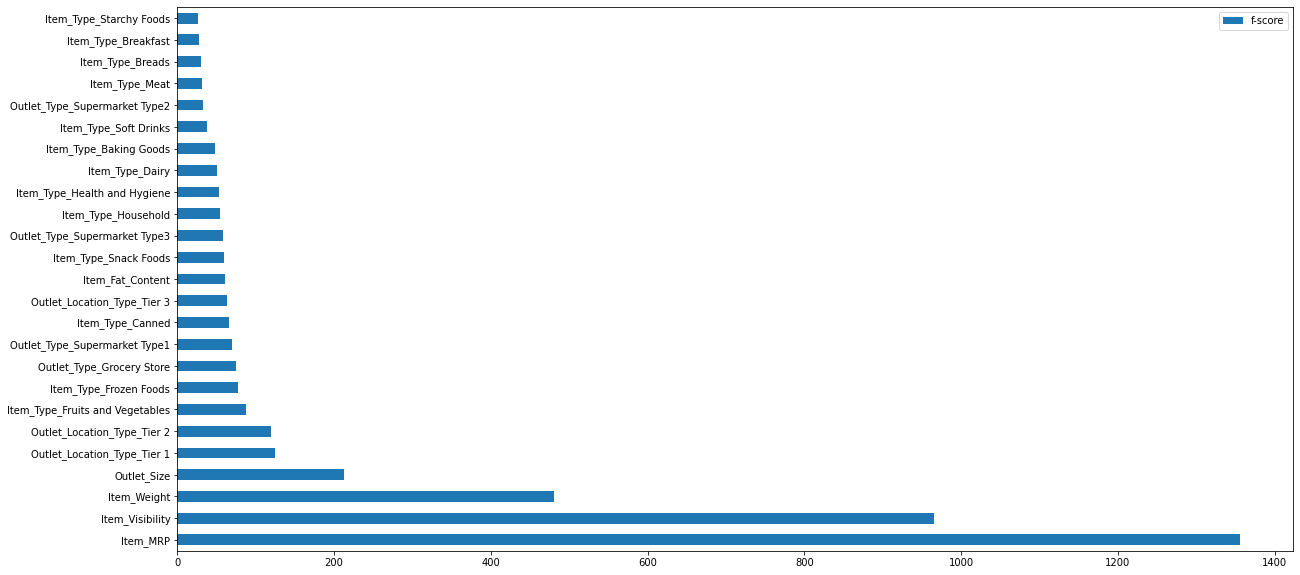

In [ ]:
feature_important = my_model.get_booster().get_fscore()
keys = list(feature_important.keys())
values = list(feature_important.values())

data = pd.DataFrame(data=values, index=keys, columns=["f-score"]).sort_values(by = "f-score", ascending=False)
data.nlargest(25, columns="f-score").plot(kind='barh', figsize = (20,10)) ## plot top 25 features

We will look at SHAP values for a single row of the dataset (we arbitrarily chose index 5223). For context, we'll look at the raw predictions before looking at the SHAP values.

In [ ]:
index_to_show = 5223

 # use 1 row of data here. Could use multiple rows if desired
data_for_prediction = Xprocessed_test_df.loc[[5223]]
my_model.predict(data_for_prediction)

array([4958.5107], dtype=float32)

The store and SKU have a predicted total sales of 4959 rupees.

Now, we'll move onto the code to get SHAP values for that single prediction.

In [ ]:
#import shap  # package used to calculate Shap values

shap.initjs()
# Create object that can calculate shap values
explainer = shap.TreeExplainer(my_model)

# Calculate Shap values
shap_values = explainer.shap_values(data_for_prediction)

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


In [ ]:
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values, data_for_prediction)

According to this force plot, the base value for sales is 2179 rupees.
The store sales for this particular example is 4959 rupees.
The most influential factor that contributed to increasing the sales was: the store being a Supermarket Type 3, the Maximum Retail Price and that the store outlet was not a Grocery Store. The item visibility, the area dedicated in the store to this item, was the biggest factor reducing the sales estimate.

If you look carefully at the code where we created the SHAP values, you'll notice we reference Trees in `shap.TreeExplainer(my_model)`.  But the SHAP package has explainers for every type of model.

- `shap.DeepExplainer` works with Deep Learning models. 
- `shap.KernelExplainer` works with all models, though it is slower than other Explainers and it offers an approximation rather than exact Shap values.

Here is an example using KernelExplainer to get similar results. The results aren't identical because `KernelExplainer` gives an approximate result. But the results tell the same story.

In [ ]:
# use Kernel SHAP to explain test set predictions
k_explainer = shap.KernelExplainer(my_model.predict, Xprocessed_train_df)
k_shap_values = k_explainer.shap_values(data_for_prediction)
shap.initjs()

shap.force_plot(k_explainer.expected_value, k_shap_values, data_for_prediction)

  0%|          | 0/1 [00:00<?, ?it/s]

---
# 3. Advanced Uses of SHAP Values 

Shap values show how much a given feature changed our prediction (compared to if we made that prediction at some baseline value of that feature).

For example, consider an ultra-simple model:
    $$y = 4 * x1 + 2 * x2$$

If $x1$ takes the value 2, instead of a baseline value of 0, then our SHAP value for $x1$ would be 8 (from 4 times 2).

These are harder to calculate with the sophisticated models we use in practice. But through some algorithmic cleverness, Shap values allow us to decompose any prediction into the sum of effects of each feature value, yielding a graph like this:

![Imgur](https://i.ibb.co/GvtpDf6/Screenshot-from-2023-03-13-07-18-26.png)

In addition to this nice breakdown for each prediction, the [Shap library](https://github.com/slundberg/shap) offers great visualizations of groups of Shap values. We will focus on two of these visualizations. These visualizations have conceptual similarities to permutation importance. So threads from the previous exercises will come together here.


## SHAP Summary Plots

Permutation importance is great because it created simple numeric measures to see which features mattered to a model. This helped us make comparisons between features easily, and you can present the resulting graphs to non-technical audiences.

But it doesn't tell you how each features matter. If a feature has medium permutation importance, that could mean it has
- a large effect for a few predictions, but no effect in general, or
- a medium effect for all predictions.

SHAP summary plots give us a birds-eye view of feature importance and what is driving it. We'll walk through an example plot for the Bigmart data:

In [ ]:
# Create object that can calculate shap values
explainer = shap.TreeExplainer(my_model)

# calculate shap values. This is what we will plot.
# Calculate shap_values for all of Xprocessed_test_df rather than a single row, to have more data for plot.
shap_values = explainer.shap_values(Xprocessed_test_df)

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


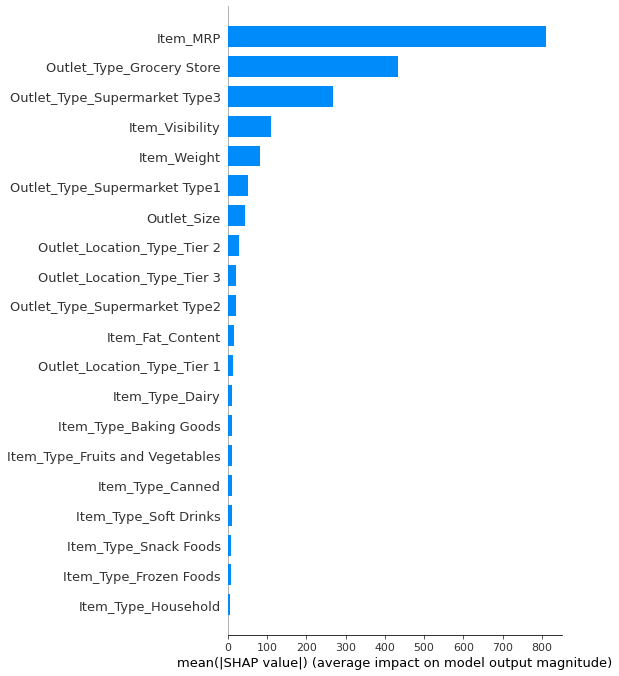

In [ ]:
shap.initjs()

shap.summary_plot(shap_values, Xprocessed_test_df, plot_type='bar')

Our shap summary plot we see that the four most impactful features are: 

* `Item_MRP`: Maximum Retail Price (list price) of the product (in rupees)
*  Whether the store is a grocery store, whether the store is a Type 3 
*  Super market
*  The item visiblity: percentage of the total display area of all products in the store allocated to that particular product

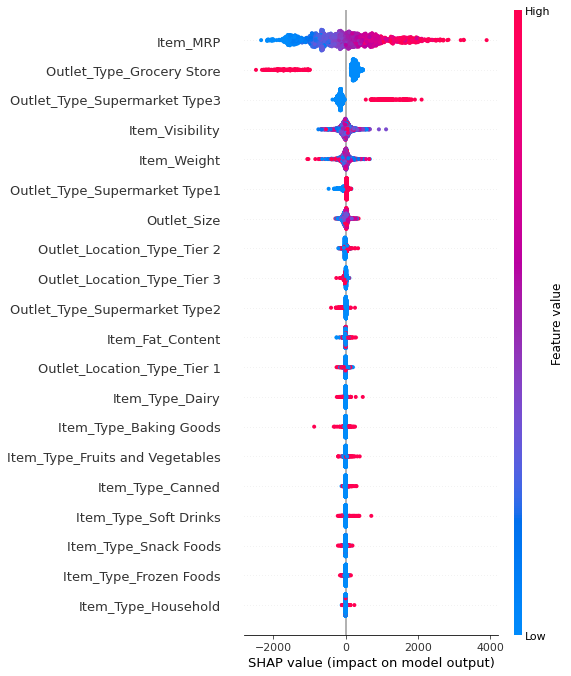

In [ ]:
shap.summary_plot(shap_values, Xprocessed_test_df)

The next plot is made of many dots, each dot has three characteristics:
- Vertical location shows what feature it is depicting
- Color shows whether that feature was high or low for that row of the dataset
- Horizontal location shows whether the effect of that value caused a higher or lower prediction.

For example, the point in the upper right was for a item and SKU that sold very well, increasing the prediction by 4000.

If you look for long enough, there's a lot of information in this graph:

According to the dot plot the `Item_MRP` is the most impactful feature in our model and very highly correlated with sales.
The higher the MRP, the higher the target value, which was the outlet sales.
If `Item_MRP` decreases, so does outlet sales

The second most impactful feature is whether the store is a grocery store or not. Grocery stores have a dramatic negative impact on the target value.

The third most impactful feature is the one-hot feature of Supermarket Type3.
Supermarkets (and especially those that are type3) produce much higher sales than grocery stores.

Finally we see that the impact of the item visiblity is a mixed bag with regard to positive or negative impact.

The code we have shown isn't too complex. But there are a few caveats.

- When plotting, we call `shap_values`.  For classification problems, there is a separate array of SHAP values for each possible outcome. In that case, we index in to get the SHAP values for the prediction of each class.
- Calculating SHAP values can be slow. It isn't a problem here, because this dataset is small.  But you'll want to be careful when running these to plot with reasonably sized datasets.  The exception is when using an `xgboost` model, which SHAP has some optimizations for and which is thus much faster.

This provides a great overview of the model, but we might want to delve into a single feature. That's where SHAP dependence contribution plots come into play.


## SHAP Dependence Contribution Plots

What is the distribution of effects? Is the effect of having a certain value pretty constant, or does it vary a lot depending on the values of other feaures. SHAP dependence contribution plots add more detail.

We get the dependence contribution plot with the following code. The only line that's different from the `summary_plot` is the last line.

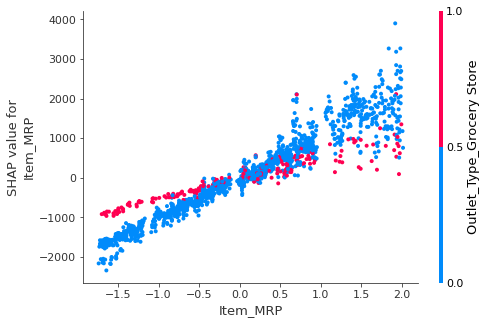

In [ ]:
shap.initjs()

# Create object that can calculate shap values
explainer = shap.TreeExplainer(my_model)

# calculate shap values. This is what we will plot.
shap_values = explainer.shap_values(Xprocessed_test_df)

# make plot.
shap.dependence_plot('Item_MRP', shap_values, Xprocessed_test_df)

Start by focusing on the shape, and we'll come back to color in a minute.  Each dot represents a row of the data. The horizontal location is the actual value from the dataset, and the vertical location shows what having that value did to the prediction.  The fact this slopes upward says that the higher the Item Max Retail Price, the higher the model's prediction is for Item Sales.

The spread suggests that other features must interact with Item Max Retail Price.  

For comparison, a simple linear regression would produce plots that are perfect lines, without this spread.

This suggests we delve into the interactions, and the plots include color coding to help do that. While the primary trend is upward, you can visually inspect whether that varies by dot color. 



If you don't supply an argument for `interaction_index`, Shapley uses some logic to pick one that may be interesting.

This didn't require writing a lot of code. But the trick with these techniques is in thinking critically about the results rather than writing code itself.